In [1]:
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
from tqdm import tqdm

# Visialisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Models
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth, SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc

# EDA

## 1. Descriptive Analysis

In [2]:
train_df = pd.read_csv('Country-data.csv')
train_df.sample(10) # Random 10 rows from the data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
15,Belgium,4.5,76.4,10.70,74.7,41100,1.880,80.0,1.86,44400
8,Austria,4.3,51.3,11.00,47.8,43200,0.873,80.5,1.44,46900
126,Rwanda,63.6,12.0,10.50,30.0,1350,2.610,64.6,4.51,563
49,Equatorial Guinea,111.0,85.8,4.48,58.9,33700,24.900,60.9,5.21,17100
119,Peru,20.3,27.8,5.08,23.8,9960,5.710,77.9,2.54,5020
100,Mauritius,15.0,51.2,6.00,62.2,15900,1.130,73.4,1.57,8000
88,Liberia,89.3,19.1,11.80,92.6,700,5.470,60.8,5.02,327
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600
130,Serbia,7.6,32.9,10.40,47.9,12700,5.880,74.7,1.40,5410
136,Solomon Islands,28.1,49.3,8.55,81.2,1780,6.810,61.7,4.24,1290


In [3]:
# Basic Decriptive Analysis
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


In [4]:
train_df.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

As we can see there are no null values in any of the columns. So 1 step less for us. Now let's move on to understanding each column...

In [5]:
train_df.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

We can see that all feature columns (except country) are numerical in nature. And the desciption makes it clear that none of them are any categorical numbers as well. So eveything is continuous. Good for us... Moving on to visualizations

In [6]:
features = [
    'child_mort', 'exports', 'health','imports',
    'income', 'inflation', 'life_expec', 'total_fer',
    'gdpp'
]

## 2. Univariate Analysis

In [7]:
# Features of smilar scales grouped together for better visibility
features_1 = [
    'income', 'gdpp'
]

features_2 = [
    'child_mort', 'exports','imports',
    'inflation', 'life_expec'
]

features_3 = [
    'health','total_fer'
]

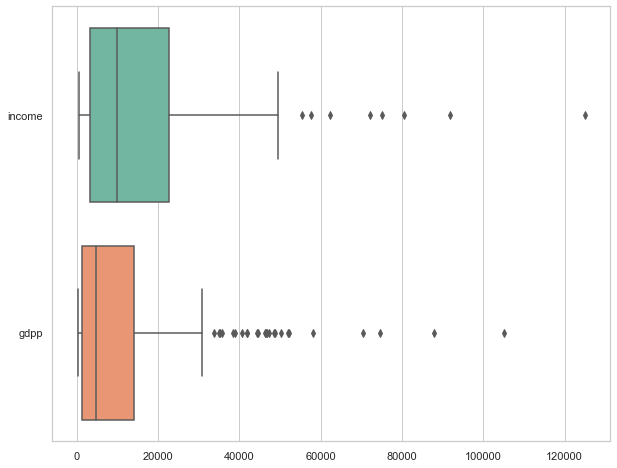

In [8]:
plt.figure(figsize=(10,8))
sns.boxplot(data=train_df[features_1], orient="h", palette="Set2");

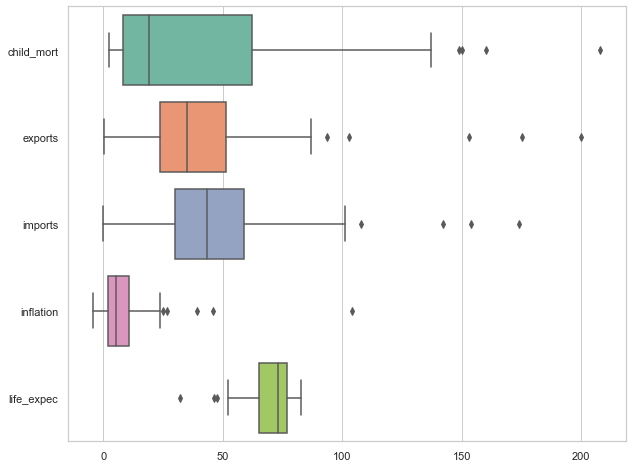

In [9]:
plt.figure(figsize=(10,8))
sns.boxplot(data=train_df[features_2], orient="h", palette="Set2");

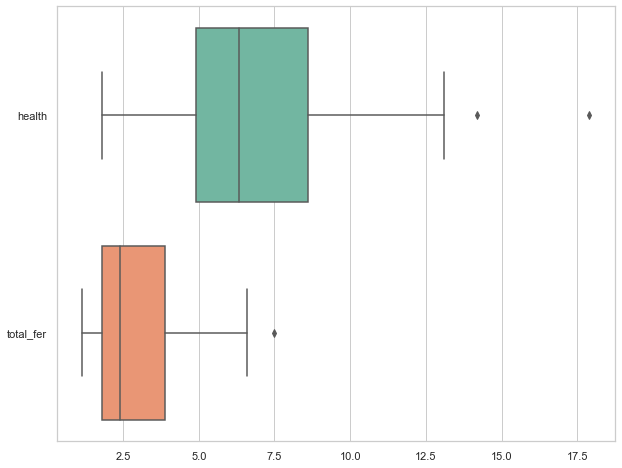

In [10]:
plt.figure(figsize=(10,8))
sns.boxplot(data=train_df[features_3], orient="h", palette="Set2");

## 3. Pair-Wise Analysis

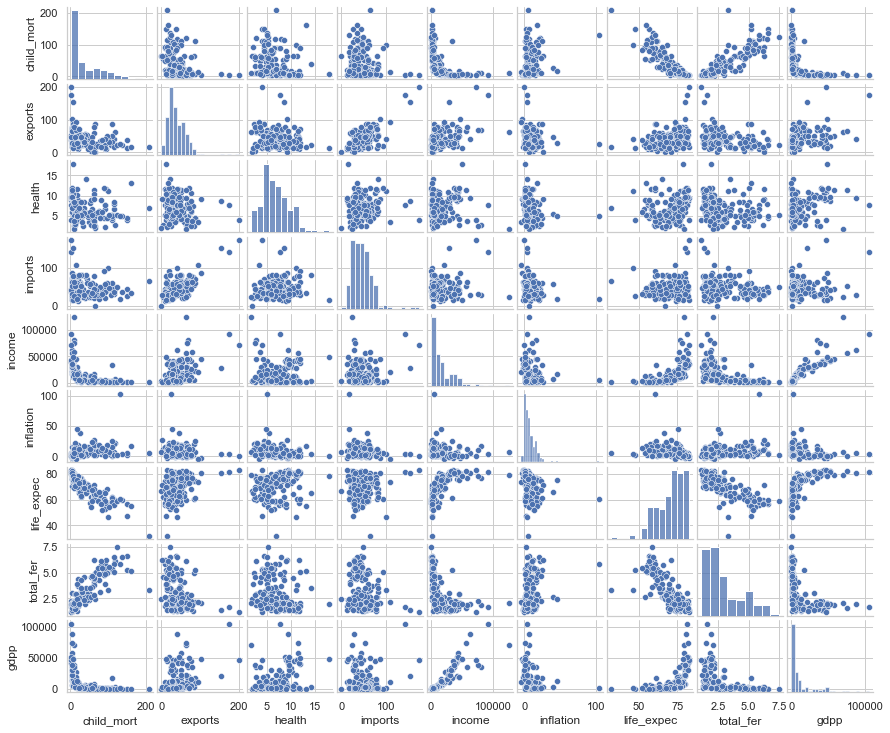

In [11]:
g = sns.pairplot(train_df[features])
g.fig.set_size_inches(12,10)

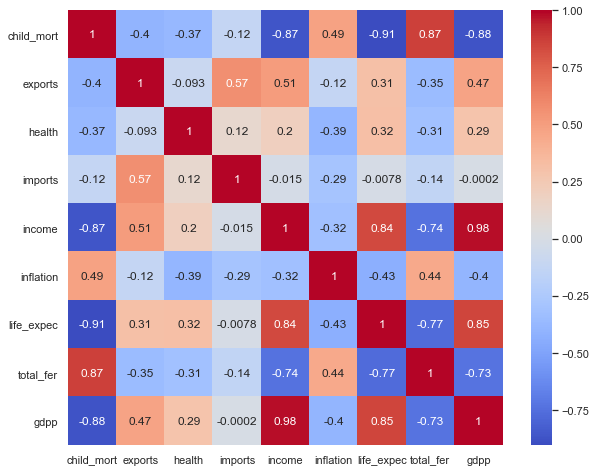

In [12]:
train_df_cor_spear = train_df[features].corr(method='spearman')
plt.figure(figsize=(10,8))
sns.heatmap(train_df_cor_spear, square=True, cmap='coolwarm', annot=True);

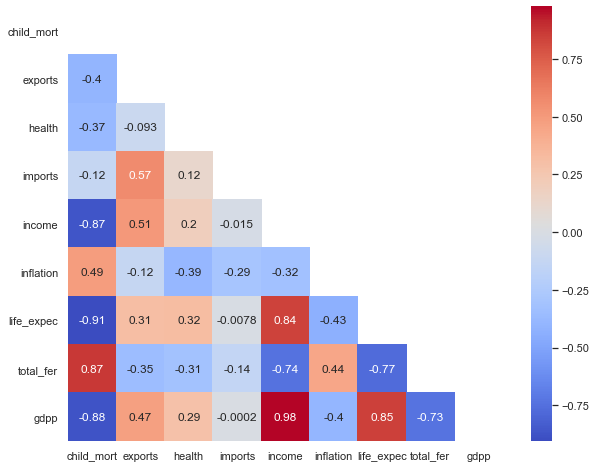

In [13]:
train_df_cor_spear = train_df[features].corr(method='spearman')
mask = np.zeros_like(train_df_cor_spear)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,8))
sns.heatmap(train_df_cor_spear, mask=mask, square=True, cmap='coolwarm', annot=True);

# Feature Engineering

In [14]:
features_to_drop = ['gdpp', 'child_mort', 'total_fer']
train_df.drop(features_to_drop, axis=1, inplace=True)

In [15]:
train_df['Trade_Deficiency'] = train_df['exports'] - train_df['imports']

In [16]:
features = [feat for feat in train_df.columns if feat not in ['country']]
print(features)

['exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'Trade_Deficiency']


In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df[features])
scaled_data = pd.DataFrame(scaled_data, columns=features)

In [18]:
def project_to_2d(df, features=features, plot=False, cluster=None):
    pca = PCA(n_components=2)
    projected = pca.fit_transform(df[features])
    if plot:
        if cluster is None:
            sns.scatterplot(
                x=projected[:, 0],
                y=projected[:, 1]
            )
        elif cluster is not None:
            num_clusters = df[cluster].nunique()
            sns.scatterplot(
                x=projected[:, 0],
                y=projected[:, 1],
                hue=df[cluster].values,
                palette=sns.color_palette("husl", num_clusters)
            )
    return projected

In [19]:
def pair_plot_cluster(df, scaled_data, cluster, features=features):
    df[cluster] = scaled_data[cluster]
    num_clusters = df[cluster].nunique()
    g = sns.pairplot(
        df[features + [cluster]],
        hue=cluster,
        palette=sns.color_palette("husl", num_clusters)
    )
    g.fig.set_size_inches(12,10)
    plt.show()

In [20]:
RANDOM_SEED = 42

Before we cluster the data, let's look at how it looks in a 2-D projection.

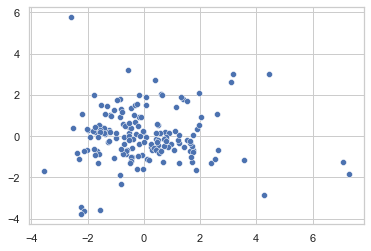

In [21]:
projected_df = project_to_2d(scaled_data, features, plot=True)

# Model Creation
We will be generating various models and discussed earlier. And we will use the utility functions defined above to judge and derive inferences from various models.

# 1. KMeans  
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. This algorithm requires the number of clusters to be specified. It scales well to large number of samples and has been used across a large range of application areas in many different fields.

In [22]:
model = KMeans(n_clusters=2, init='k-means++', random_state=RANDOM_SEED)
# 2 is just an arbitrary number, we will find the exact number soon below

model.fit(scaled_data[features])
scaled_data['KMeans'] = model.predict(scaled_data[features])

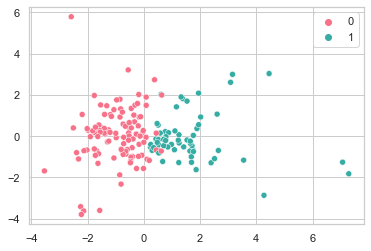

In [23]:
projected_df = project_to_2d(scaled_data, features, plot=True, cluster='KMeans')

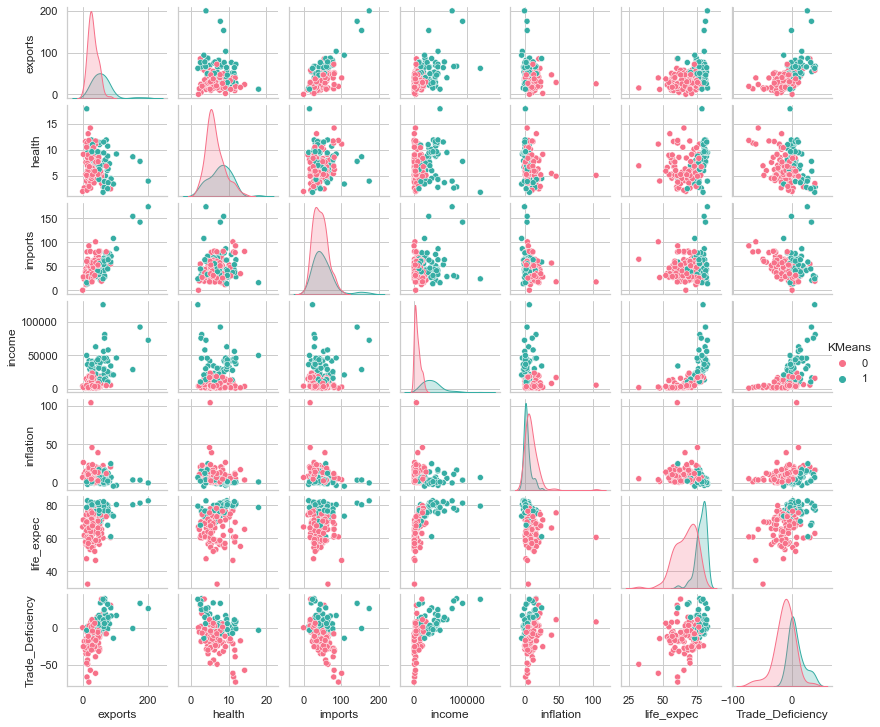

In [24]:
pair_plot_cluster(train_df, scaled_data, 'KMeans')

There are 2 broad methods to find the optimal number of clusters, let's look at them, one by one...
### A. Elbow Method  
In this method we iterate over various number of probable clusters and find the overall inertia of the clusters. The plot of the same forms a hard like structure with shoulders, elbow, forearm, etc. Based on this we **"eyeball"** and try to find the elbow of this plot and take this as our optimal nummber of cluster.

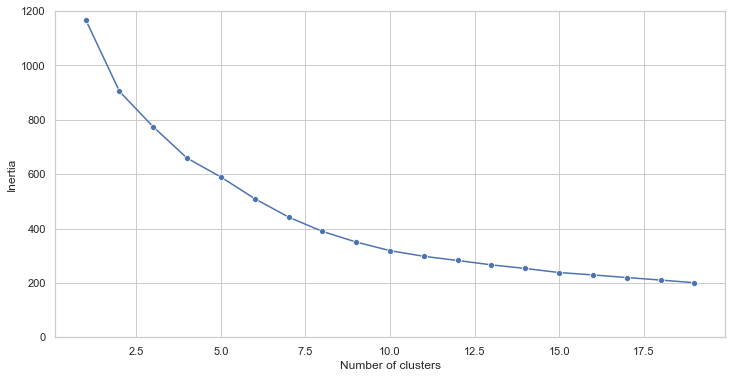

In [25]:
INERTIAS = []
for cluster in range(1,20):
    model = KMeans(n_clusters = cluster, init='k-means++',
                   n_jobs = -1, random_state=RANDOM_SEED)
    model.fit(scaled_data[features])
    INERTIAS.append(model.inertia_)

inert_df = pd.DataFrame({'Num_Clusters':range(1,20), 'Inertia':INERTIAS})
plt.figure(figsize=(12,6))
sns.lineplot(data=inert_df, x="Num_Clusters", y="Inertia", marker='o')
plt.ylim(0, 1200)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia');

Based on this image it looks like our elbow lies somewhere in the 3-7 region. Let's take 3 as our optimal number of cluster.

In [26]:
model = KMeans(n_clusters=3, init='k-means++', random_state=RANDOM_SEED)
model.fit(scaled_data[features])
scaled_data['KMeans'] = model.predict(scaled_data[features])

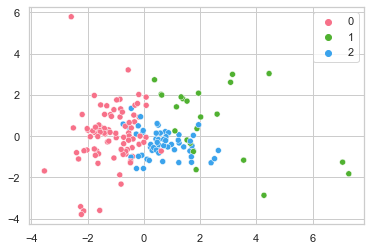

In [27]:
projected_df = project_to_2d(scaled_data, features, plot=True, cluster='KMeans')

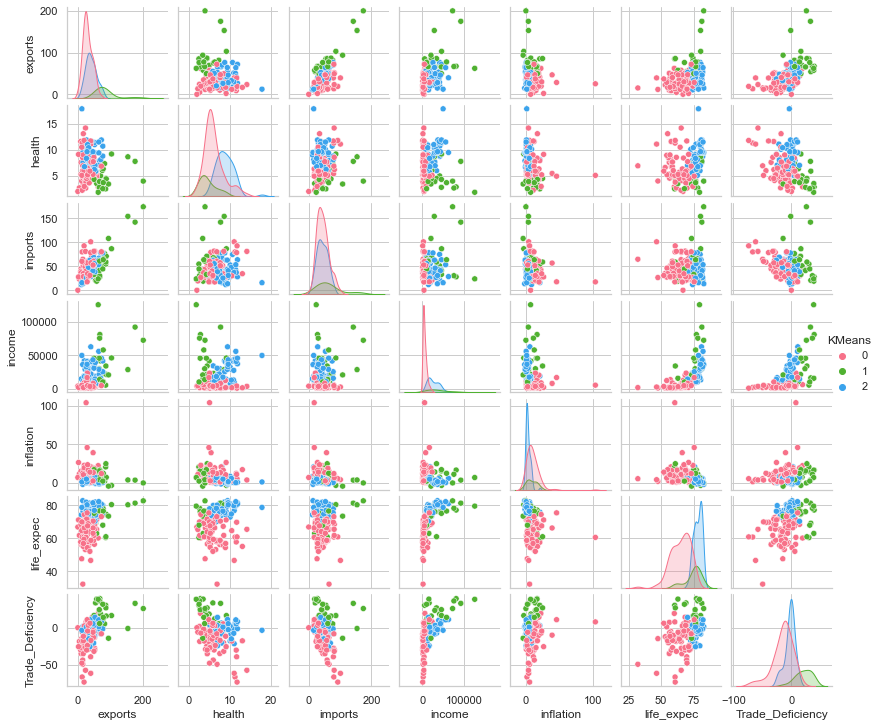

In [28]:
pair_plot_cluster(train_df, scaled_data, 'KMeans')

As you might have guessed, this method is very subjective and involves a lot of eyeballing and assumptions. Which can be quite trivial and frankly we are going to encounter much more complex ploblems than this in real life. So, let's try the second method.
### B. Silhouette Coefficient Method
A higher Silhouette Coefficient score relates to a model with better defined clusters. The Silhouette Coefficient is defined for each sample and is composed of two scores:
* The mean distance between a sample and all other points in the same class.
* The mean distance between a sample and all other points in the next nearest cluster.

Finally, the Total Silhouette Coefficient for a set of samples is given as the mean of the Silhouette Coefficient for each sample.

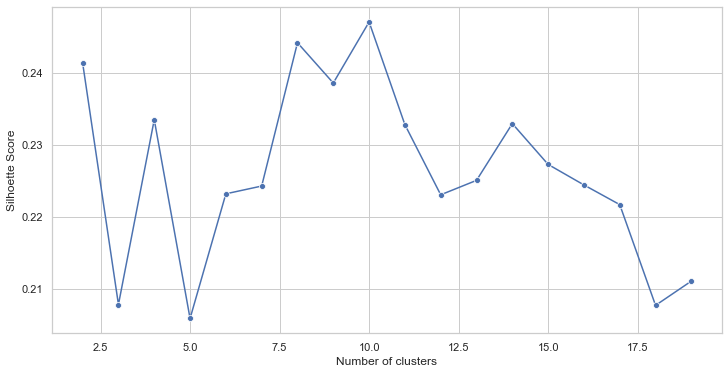

In [29]:
SILHOUETTES = []
for cluster in range(2,20):
    model = KMeans(
        n_clusters = cluster, init='k-means++',
        n_jobs = -1, random_state=RANDOM_SEED)
    model.fit(scaled_data[features])
    labels = model.labels_
    SILHOUETTES.append(silhouette_score(
        scaled_data[features],
        labels, metric = 'euclidean'
    ))

inert_df = pd.DataFrame({'Num_Clusters':range(2,20), 'Silhoette':SILHOUETTES})
plt.figure(figsize=(12,6))
sns.lineplot(data=inert_df, x="Num_Clusters", y="Silhoette", marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhoette Score');

Here we see that we have a clear peak at 2, thus our optimal number of clusters as per kmeans is 2.  
As you can see Silhouette method is much more objective in nature and we do not have to guess the position.

***NOTE:- You might be wondering why we do not set a very high number of clusters. That is because the inertia of the clusters will always keep decreasing as we increase the number of clusters until we have exactly the number of points in the dataset. But this will defy the purpose, we do not want 100% purity, but we want to group toghether SIMILAR data points.***

In [30]:
model = KMeans(n_clusters=2, init='k-means++', random_state=RANDOM_SEED)
model.fit(scaled_data[features])
scaled_data['KMeans'] = model.predict(scaled_data[features])

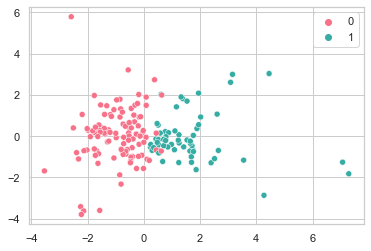

In [31]:
projected_df = project_to_2d(scaled_data, features, plot=True, cluster='KMeans')

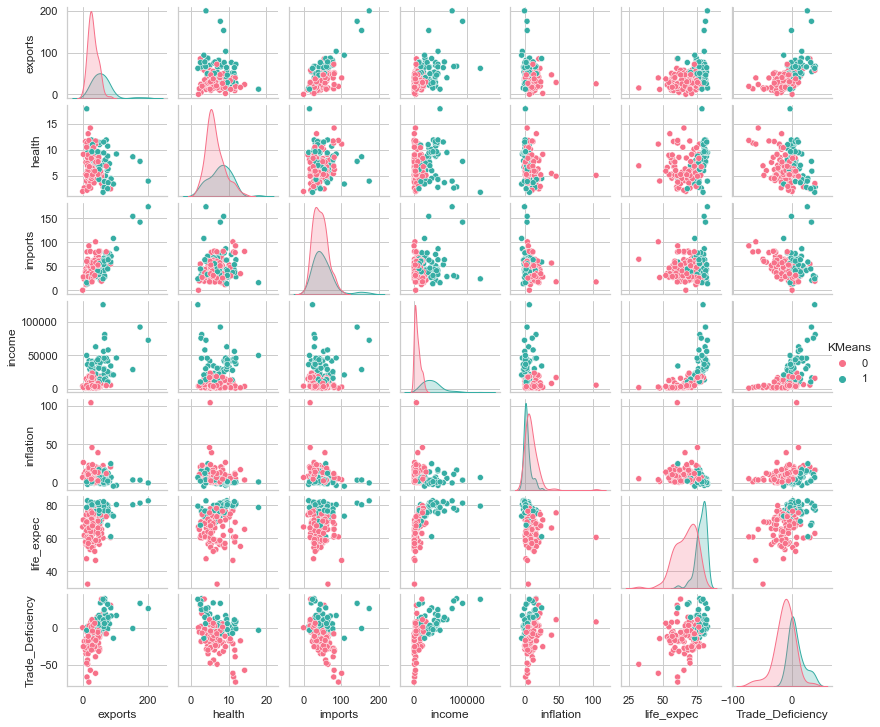

In [32]:
pair_plot_cluster(train_df, scaled_data, 'KMeans')

Here we see the differenciating factors among various clusters are Income, Health and Life expectancy. Which happen to be key indicators of lifestyle.  
So based on these we can classify the nations into 'Healthy Lifestyle' and 'Unhealthy Lifestyle'.
### Predictions

In [33]:
label_dict = {
    0 : 'Unhealthy Lifestyle',
    1 : 'Healthy Lifestyle'
}

train_df['Kmeans_Prediction'] = train_df['KMeans'].map(label_dict)

There can be nations where people earn a lot but do not spend on healthcare or vice-versa. This broad category takes care of that as well. Let's see some example of each class...

In [34]:
print(train_df[train_df['Kmeans_Prediction'] == 'Healthy Lifestyle'].sample(10)['country'].to_list())

['Malaysia', 'United States', 'Suriname', 'Germany', 'Estonia', 'Czech Republic', 'Chile', 'Cyprus', 'Luxembourg', 'Bulgaria']


In [35]:
print(train_df[train_df['Kmeans_Prediction'] == 'Unhealthy Lifestyle'].sample(10)['country'].to_list())

['Zambia', 'Cameroon', 'Kazakhstan', 'Tanzania', 'Benin', 'Comoros', 'Central African Republic', 'Bolivia', 'India', 'Rwanda']


# 2. Hierarchical Clustering
In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. This is an unsupervised clustering algorithm which involves creating clusters that have predominant ordering. Strategies for hierarchical clustering generally fall into two types:
1. Agglomerative Hierarchical Clustering
2. Divisive Hierarchical Clustering

And unlike kMeans we have to use **dendogram method** here to determine the number of ideal clusters as per hierarchy. What is dendogram method? Let me explain:-

### Dendogram
We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters.
1. Determine the largest vertical distance that doesn’t intersect any of the other clusters.
2. Draw a horizontal line at both extremities.
3. The optimal number of clusters is equal to the number of vertical lines going through the horizontal line.

![](https://miro.medium.com/proxy/1*LBOReupihNEsI6Kot3Q6YQ.png)
Source:- [Medium](https://towardsdatascience.com/machine-learning-algorithms-part-12-hierarchical-agglomerative-clustering-example-in-python-1e18e0075019)  
In this example, the ideal number of cluster will be 4. Now let's draw a similar diagram for our problem...

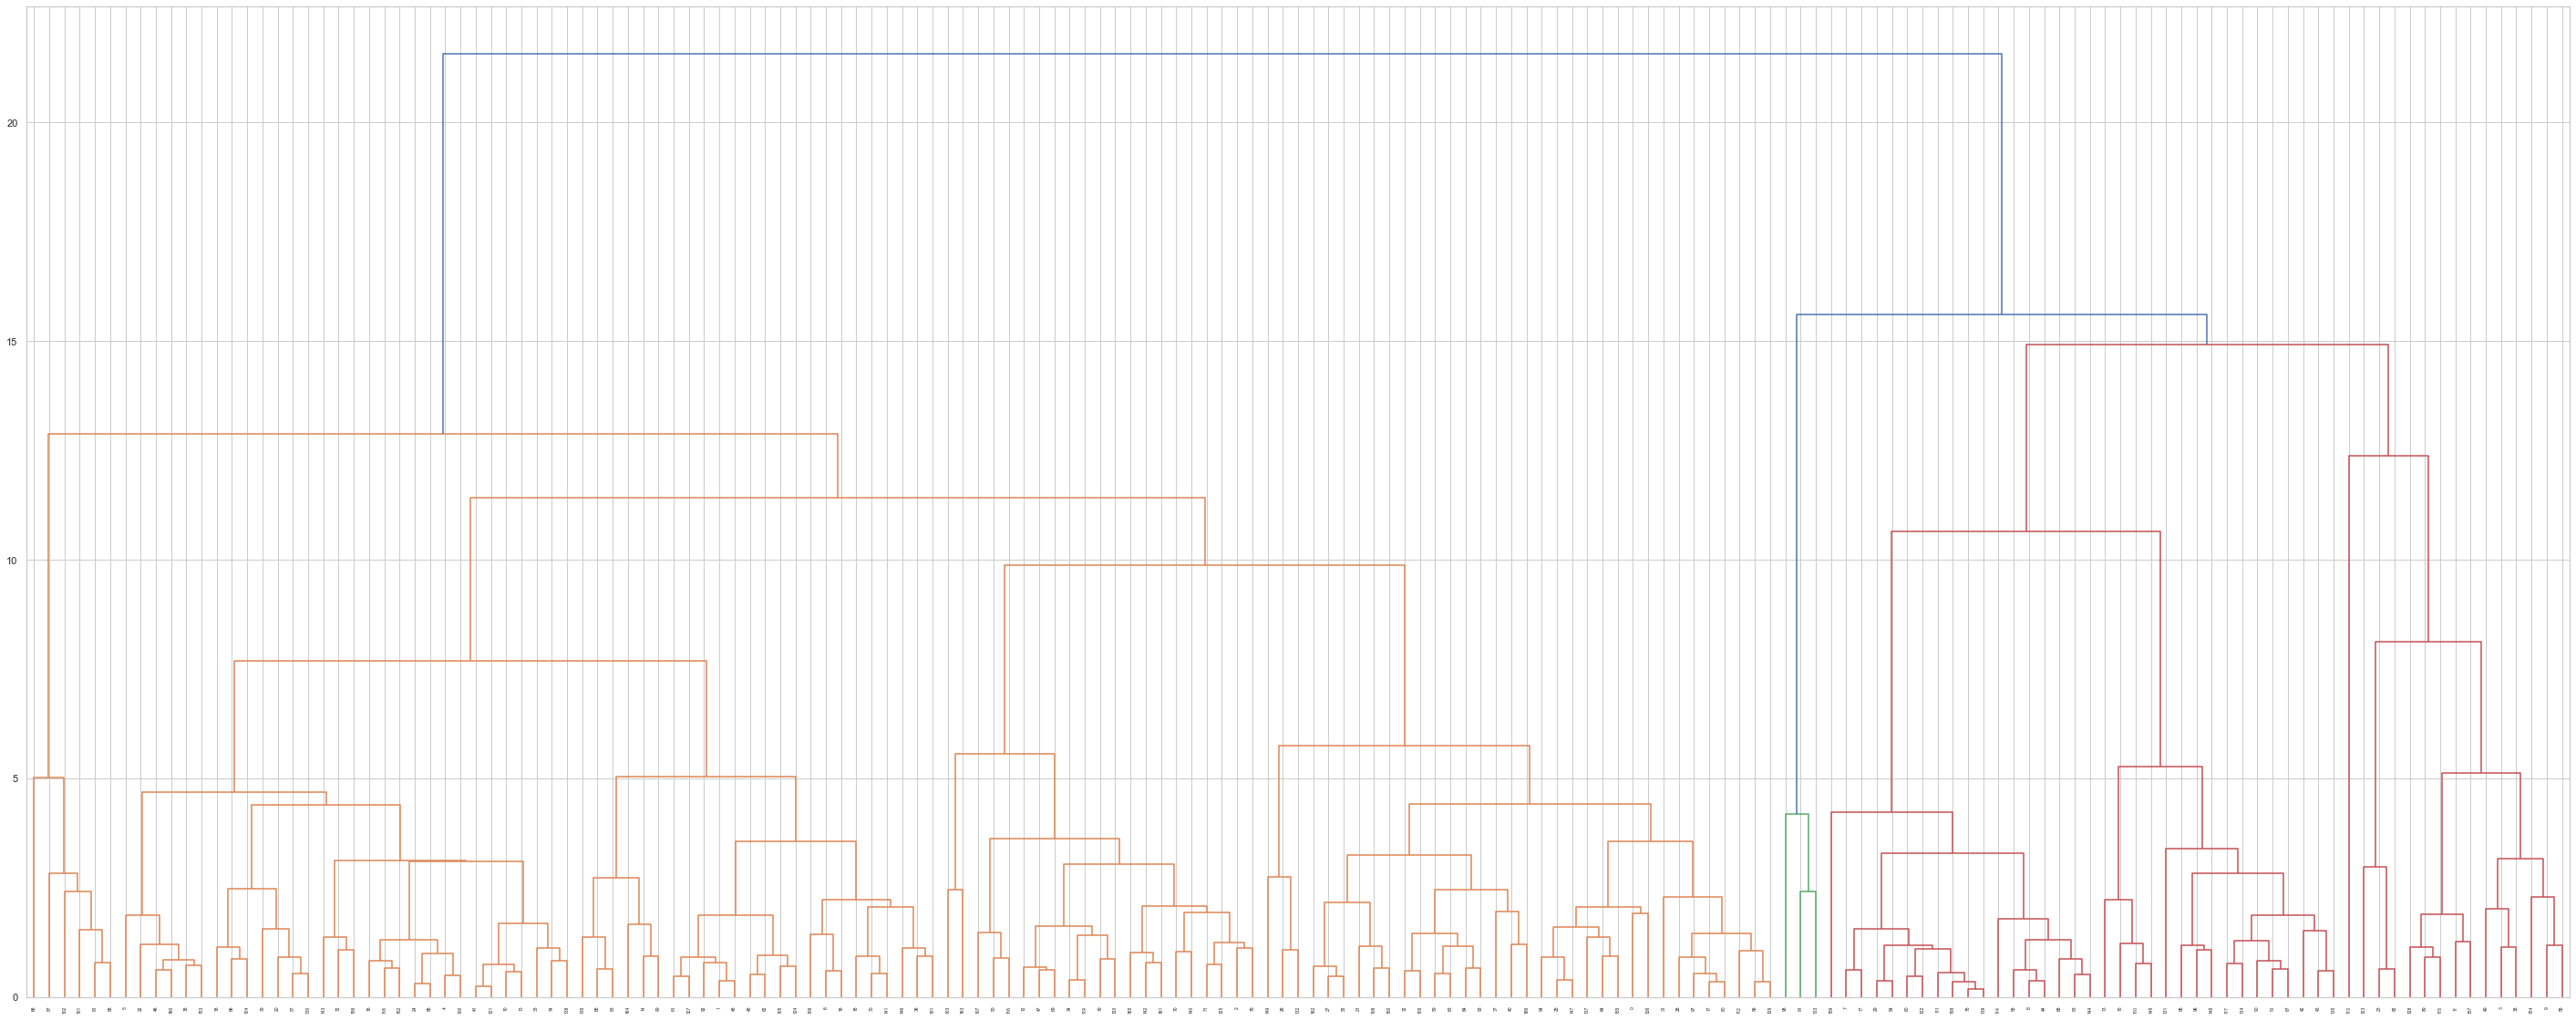

In [36]:
plt.figure(figsize=(50, 20))
_ = shc.dendrogram(shc.linkage(scaled_data[features], method='ward'))

So in our case the optimal number of clusters will be **2** using the dendogram method.  
### Agglomerative Hierarchical Clustering
Bottom up approach. Start with many small clusters and merge them together to create bigger clusters.  

In [37]:
model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model.fit(scaled_data[features])
scaled_data['Agglomerative_H'] = model.labels_

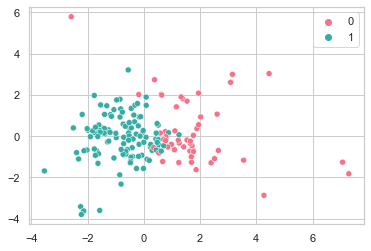

In [38]:
projected_df = project_to_2d(scaled_data, features, plot=True, cluster='Agglomerative_H')

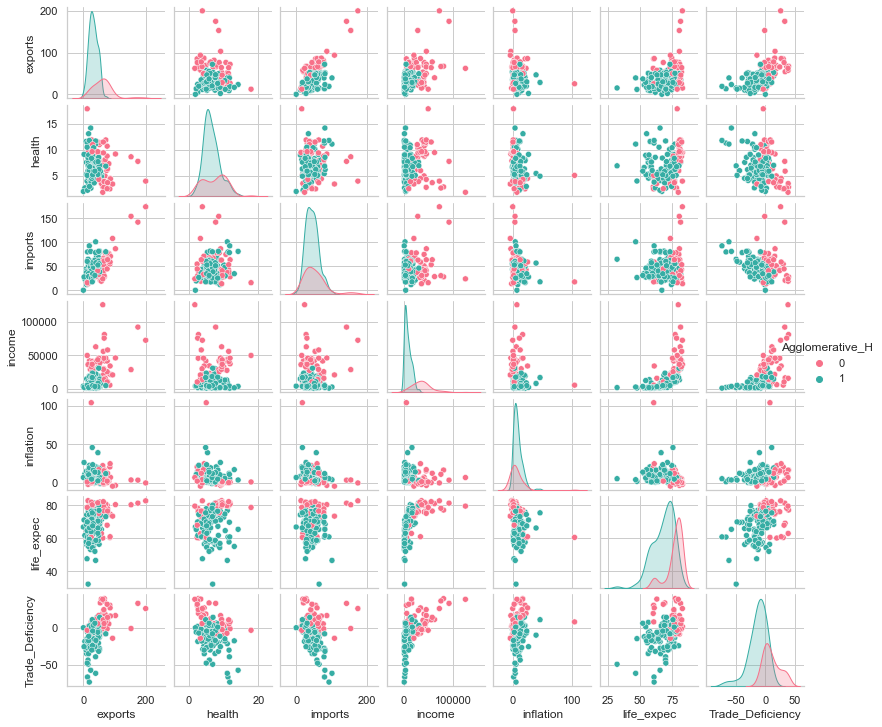

In [39]:
pair_plot_cluster(train_df, scaled_data, 'Agglomerative_H')

### Predictions

In [40]:
label_dict = {
    0 : 'Healthy Lifestyle',
    1 : 'Unhealthy Lifestyle'
}

train_df['Agglomerative_Prediction'] = train_df['Agglomerative_H'].map(label_dict)

In [41]:
print(train_df[train_df['Agglomerative_Prediction'] == 'Healthy Lifestyle'].sample(10)['country'].to_list())

['Congo, Rep.', 'Azerbaijan', 'Switzerland', 'France', 'Belgium', 'Greece', 'Finland', 'Turkmenistan', 'Germany', 'Netherlands']


In [42]:
print(train_df[train_df['Agglomerative_Prediction'] == 'Unhealthy Lifestyle'].sample(10)['country'].to_list())

['Comoros', 'Mozambique', 'Cameroon', 'El Salvador', 'Bahamas', 'Peru', 'Suriname', 'Zambia', 'Lesotho', 'Namibia']
